In [3]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.10.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
# TransNetV-Seg: CNN–Transformer Encoder + UNet Decoder for Multichannel Masks

import os, math, tensorflow as tf
from typing import Tuple, List
from tensorflow.keras import layers as L, Model
from tensorflow.keras.applications import ResNet50

# ---------------------------
# Global setup
# ---------------------------
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ---------------------------
# Data pipeline (images/, masks/)
# - images: RGB PNG/JPG
# - masks:  single-channel PNG with integer labels [0..num_classes-1]
# ---------------------------
def build_seg_dataset(
        images_dir: str,
        masks_dir: str,
        image_size: Tuple[int, int] = (512, 512),
        batch_size: int = 4,
        num_classes: int = 6,
        shuffle: bool = True,
        augment: bool = True,
) -> tf.data.Dataset:
    AUTOTUNE = tf.data.AUTOTUNE

    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    mask_files  = sorted([os.path.join(masks_dir,  f) for f in os.listdir(masks_dir)  if f.lower().endswith(('.png','.jpg','.jpeg'))])
    assert len(image_files) == len(mask_files) and len(image_files) > 0, "Images/masks count mismatch or empty."

    ds_images = tf.data.Dataset.from_tensor_slices(image_files)
    ds_masks  = tf.data.Dataset.from_tensor_slices(mask_files)
    ds = tf.data.Dataset.zip((ds_images, ds_masks))

    def read_img_mask(img_p, msk_p):
        img = tf.io.read_file(img_p); img = tf.image.decode_image(img, channels=3, expand_animations=False)
        msk = tf.io.read_file(msk_p);  msk = tf.image.decode_image(msk, channels=1, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, image_size, method='bilinear')
        # mask is integer labels; ensure shape and type
        msk = tf.image.resize(msk, image_size, method='nearest')  # keep labels intact
        msk = tf.cast(msk, tf.int32)
        # one-hot mask [H,W,C]
        msk_oh = tf.one_hot(tf.squeeze(msk, axis=-1), depth=num_classes, dtype=tf.float32)
        return img, msk_oh

    def augment_pair(img, m):
        # Simple strong-but-safe augmentations for H&E
        if augment:
            if tf.random.uniform(()) > 0.5:
                img = tf.image.flip_left_right(img); m = tf.image.flip_left_right(m)
            if tf.random.uniform(()) > 0.5:
                img = tf.image.flip_up_down(img); m = tf.image.flip_up_down(m)
            # small rotation
            k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
            img = tf.image.rot90(img, k); m = tf.image.rot90(m, k)
        return img, m

    if shuffle: ds = ds.shuffle(buffer_size=len(image_files), reshuffle_each_iteration=True)
    ds = ds.map(read_img_mask, num_parallel_calls=AUTOTUNE).map(augment_pair, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
    return ds

# ---------------------------
# Transformer blocks (on spatial tokens)
# ---------------------------
def mhsa_ffn_block(x, num_heads: int, d_model: int, mlp_dim: int, attn_dropout=0.0, drop=0.0):
    """ Pre-LN Transformer block: LN -> MHSA -> Drop -> Residual, then LN -> FFN -> Drop -> Residual """
    # Multi-Head Self-Attention
    y = L.LayerNormalization(epsilon=1e-6)(x)
    y = L.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=attn_dropout)(y, y)
    y = L.Dropout(drop)(y)
    x = L.Add()([x, y])

    # MLP
    y = L.LayerNormalization(epsilon=1e-6)(x)
    y = L.Dense(mlp_dim, activation="gelu")(y)
    y = L.Dropout(drop)(y)
    y = L.Dense(d_model)(y)
    y = L.Dropout(drop)(y)
    return L.Add()([x, y])

# ---------------------------
# Positional embedding for HxW tokens
# ---------------------------
def build_2d_pos_embed(h: int, w: int, d_model: int, name="pos_embed"):
    # Learned positional embedding [1, H*W, D]
    pe = tf.Variable(
        initial_value=tf.random.normal(shape=(1, h*w, d_model), stddev=0.02, dtype=tf.float32),
        trainable=True, name=name
    )
    return pe

# ---------------------------
# Decoder blocks
# ---------------------------
def conv_bn_relu(x, filters, k=3):
    x = L.Conv2D(filters, k, padding="same", use_bias=False)(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    return x

def up_block(x, skip, filters):
    x = L.UpSampling2D(size=(2,2), interpolation='bilinear')(x)
    if skip is not None:
        x = L.Concatenate()([x, skip])
    x = conv_bn_relu(x, filters); x = conv_bn_relu(x, filters)
    return x

# ---------------------------
# Build TransNetV-Seg model
# ---------------------------
def build_transnetv_seg(
        input_shape=(512,512,3),
        num_classes=6,
        d_model=384,
        num_heads=6,
        mlp_dim=1024,
        num_transformer_layers=4,
        attn_dropout=0.0,
        drop=0.0,
        fine_tune_at=None,
):
    """
    Encoder: ResNet50 -> {C2,C3,C4,C5}, project C5 to d_model.
    Transformer: tokens on C5 with learned 2D positional embeddings, L layers.
    Decoder: UNet-like with skip connections.
    Output: HxW x num_classes (softmax).
    """
    inp = L.Input(shape=input_shape)

    # --- Conv Encoder (ResNet50)
    base = ResNet50(include_top=False, weights="imagenet", input_tensor=inp)
    # Skip features
    C2 = base.get_layer("conv2_block3_out").output   # 1/4
    C3 = base.get_layer("conv3_block4_out").output   # 1/8
    C4 = base.get_layer("conv4_block6_out").output   # 1/16
    C5 = base.get_layer("conv5_block3_out").output   # 1/32  (h5,w5,2048)

    # Optionally freeze early layers
    if fine_tune_at is not None:
        for i, layer in enumerate(base.layers[:fine_tune_at]):
            if not isinstance(layer, L.BatchNormalization):
                layer.trainable = False

    # --- Project C5 to d_model and tokenize
    h5 = tf.shape(C5)[1]; w5 = tf.shape(C5)[2]  # dynamic for graph; needed for reshaping
    x = L.Conv2D(d_model, kernel_size=1, padding="same", use_bias=False, name="c5_proj")(C5)  # (B,h5,w5,d_model)
    H5 = tf.keras.backend.int_shape(C5)[1] or (input_shape[0] // 32)
    W5 = tf.keras.backend.int_shape(C5)[2] or (input_shape[1] // 32)

    x_tokens = L.Reshape((H5*W5, d_model))(x)  # (B, N, D)
    pos_embed = build_2d_pos_embed(H5, W5, d_model)  # (1,N,D)
    x_tokens = L.Add(name="add_pos")([x_tokens, pos_embed])

    # --- Transformer encoder (L layers)
    for i in range(num_transformer_layers):
        x_tokens = mhsa_ffn_block(x_tokens, num_heads, d_model, mlp_dim, attn_dropout, drop)

    # --- Back to feature map (C5')
    x_tf = L.Reshape((H5, W5, d_model))(x_tokens)  # (B,h5,w5,d_model)

    # --- Decoder with skip connections (UNet-like)
    # Reduce skip depths to reasonable channel counts
    C2r = L.Conv2D(128, 1, padding="same")(C2)
    C3r = L.Conv2D(256, 1, padding="same")(C3)
    C4r = L.Conv2D(384, 1, padding="same")(C4)

    d5 = conv_bn_relu(x_tf, 512); d5 = conv_bn_relu(d5, 512)           # 1/32
    d4 = up_block(d5, C4r, 384)                                        # 1/16
    d3 = up_block(d4, C3r, 256)                                        # 1/8
    d2 = up_block(d3, C2r, 128)                                        # 1/4
    d1 = L.UpSampling2D(size=(4,4), interpolation='bilinear')(d2)      # back to 1/1

    # Final refinement
    d1 = conv_bn_relu(d1, 96); d1 = conv_bn_relu(d1, 64)

    # Segmentation logits & softmax
    logits = L.Conv2D(num_classes, kernel_size=1, dtype="float32")(d1)  # cast to float32 for numeric stability
    out = L.Softmax(name="segmentation")(logits)

    return Model(inputs=inp, outputs=out, name="TransNetV_Seg")

# ---------------------------
# Losses & Metrics
# ---------------------------
def categorical_dice_loss(y_true, y_pred, eps=1e-6):
    # y_true, y_pred: [B,H,W,C]
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    axes = (0,1,2)
    intersection = tf.reduce_sum(y_true * y_pred, axis=axes)
    denom = tf.reduce_sum(y_true + y_pred, axis=axes)
    dice = (2. * intersection + eps) / (denom + eps)
    return 1.0 - tf.reduce_mean(dice)

def combined_ce_dice(y_true, y_pred, ce_weight=0.7, dice_weight=0.3):
    ce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true, y_pred)
    dl = categorical_dice_loss(y_true, y_pred)
    return ce_weight * ce + dice_weight * dl

def build_metrics(num_classes):
    miou = tf.keras.metrics.MeanIoU(num_classes=num_classes, name="miou")
    acc  = tf.keras.metrics.CategoricalAccuracy(name="pix_acc")
    return [acc, miou]

# ---------------------------
# Example: compile & train
# ---------------------------
if __name__ == "__main__":
    # CONFIG
    IMG_SIZE = (512, 512)
    NUM_CLASSES = 6  # set to your mask channels
    BATCH = 4
    EPOCHS = 50

    # Datasets
    # Expect folders like:
    # /path/to/dataset/images/*.png
    # /path/to/dataset/masks/*.png   (single-channel integer mask)
    train_ds = build_seg_dataset(
        images_dir="/kaggle/input/train/images",
        masks_dir="/kaggle/input/train/masks",
        image_size=IMG_SIZE, batch_size=BATCH, num_classes=NUM_CLASSES, augment=True
    )
    val_ds = build_seg_dataset(
        images_dir="/kaggle/input/val/images",
        masks_dir="/kaggle/input/val/masks",
        image_size=IMG_SIZE, batch_size=BATCH, num_classes=NUM_CLASSES, augment=False, shuffle=False
    )

    # Model
    model = build_transnetv_seg(
        input_shape=(*IMG_SIZE, 3),
        num_classes=NUM_CLASSES,
        d_model=384,
        num_heads=6,
        mlp_dim=1024,
        num_transformer_layers=4,
        attn_dropout=0.0,
        drop=0.1,
        fine_tune_at=50,  # freeze early ResNet layers (except BNs)
    )

    # Optimizer (cosine decay + mixed precision)
    initial_lr = 1e-4
    steps_per_epoch = 200  # adjust to len(train_ds)
    lr_sched = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=EPOCHS * max(1, steps_per_epoch),
        alpha=1e-2
    )
    base_opt = tf.keras.optimizers.Adam(learning_rate=lr_sched)
    opt = tf.keras.mixed_precision.LossScaleOptimizer(base_opt)

    model.compile(
        optimizer=opt,
        loss=combined_ce_dice,  # or 'categorical_crossentropy'
        metrics=build_metrics(NUM_CLASSES)
    )

    # Callbacks
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        "transnetv_seg_best.h5", monitor="val_miou", mode="max",
        save_best_only=True, save_weights_only=False
    )
    csv  = tf.keras.callbacks.CSVLogger("transnetv_seg_log.csv")
    es   = tf.keras.callbacks.EarlyStopping(monitor="val_miou", mode="max", patience=12, restore_best_weights=True)

    # Train
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[ckpt, csv, es],
        verbose=1
    )

    # Save final
    model.save("transnetv_seg_final.h5")


In [4]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import skimage.io
import matplotlib.pyplot as plt
import sys, os, random, glob, cv2, math
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
tf.config.optimizer.set_jit(False)  


KeyboardInterrupt



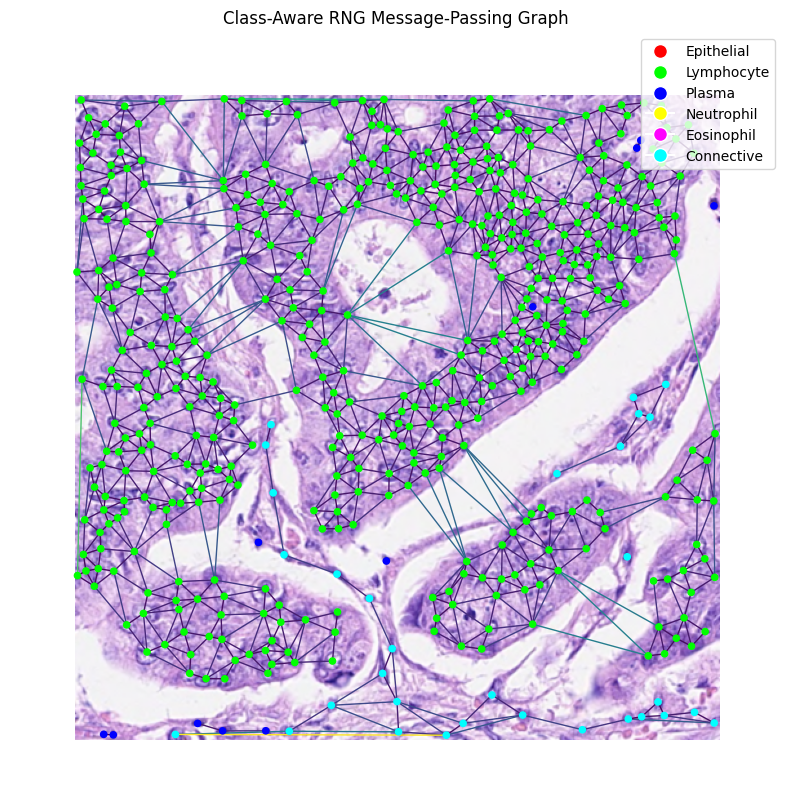

Class Vertex Counts: {'Epithelial': 0, 'Lymphocyte': 480, 'Plasma': 11, 'Neutrophil': 0, 'Eosinophil': 0, 'Connective': 31}


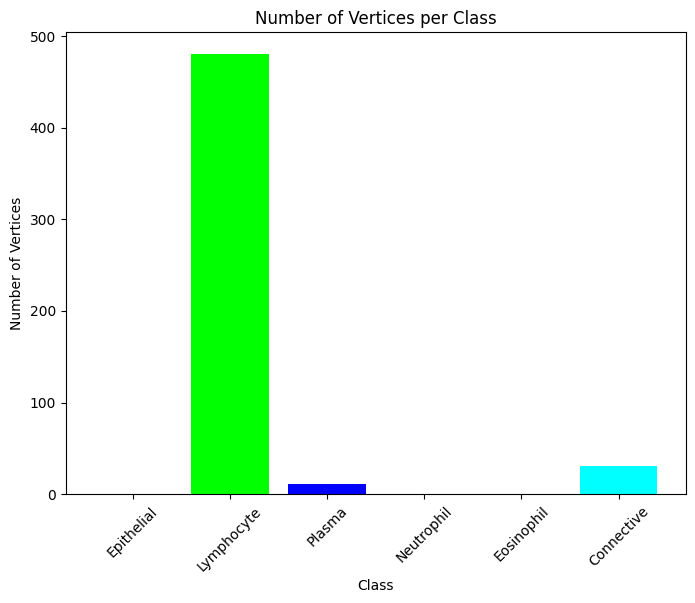

In [1]:
import os
import numpy as np
import matplotlib.colors as mcolors
import tensorflow as tf
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import networkx as nx
import scipy.io as sio
from scipy.spatial import Delaunay
from sklearn.metrics.pairwise import euclidean_distances

# Define specific colors for each class
class_colors = {
    1: (1.0, 0.0, 0.0),   # Red for Epithelial
    2: (0.0, 1.0, 0.0),   # Green for Lymphocyte
    3: (0.0, 0.0, 1.0),   # Blue for Plasma
    4: (1.0, 1.0, 0.0),   # Yellow for Neutrophil
    5: (1.0, 0.0, 1.0),   # Magenta for Eosinophil
    6: (0.0, 1.0, 1.0)    # Cyan for Connective (other)
}

# Mapping class labels to their names
class_names = {
    1: 'Epithelial',
    2: 'Lymphocyte',
    3: 'Plasma',
    4: 'Neutrophil',
    5: 'Eosinophil',
    6: 'Connective'
}

# Function to preprocess the image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure channels=3 for RGB
    image = tf.image.resize(image, [500, 500])  # Resize image to 500x500
    image = tf.cast(image, tf.float32)  # Cast to float32 before division
    image = image / 255.0  # Normalize the image to [0, 1]
    return image

# Function to load and preprocess the label from the Lizard dataset
def load_lizard_label(label_path, target_size=(500, 500)):
    label = sio.loadmat(label_path)

    # Load the instance segmentation map and resize it to match the image size
    inst_map = label['inst_map']
    inst_map_expanded = np.expand_dims(inst_map, axis=-1)  # Expand dimensions to [H, W, 1]
    inst_map_resized = tf.image.resize(tf.convert_to_tensor(inst_map_expanded, dtype=tf.float32), target_size, method='nearest').numpy()

    # Load the index array
    nuclei_id = label['id']  # shape (N, 1)
    nuclei_id = np.squeeze(nuclei_id).tolist()

    # Load the nuclear categories / classes
    classes = label['class']

    # Load the bounding boxes
    bboxs = label['bbox']

    # Load the centroids
    centroids = label['centroid']

    # Match each nucleus with its corresponding class, bbox, and centroid
    features = []
    unique_values = np.unique(inst_map).tolist()[1:]  # Remove 0 (background)

    for value in unique_values:
        # Get the position of the corresponding value
        idx = nuclei_id.index(value)
        feature = {
            'class': classes[idx],
            'bbox': bboxs[idx],
            'centroid': centroids[idx]
        }
        features.append(feature)

    return inst_map_resized.squeeze(), features  # Remove the extra channel added earlier

# Farthest Point Sampling (FPS)
def farthest_point_sampling(features, num_samples):
    centroids = np.array([feature['centroid'] for feature in features])
    
    # Start with a random point
    sampled_idxs = [np.random.randint(len(centroids))]
    
    # Compute the farthest points
    for _ in range(num_samples - 1):
        dist_matrix = euclidean_distances(centroids, centroids[sampled_idxs])
        dist_to_sampled = dist_matrix.min(axis=1)
        next_sample = dist_to_sampled.argmax()
        sampled_idxs.append(next_sample)
    
    return [features[idx] for idx in sampled_idxs]

# Build message passing graph based on Relative Neighborhood Graph (RNG) with FPS applied
def build_rng_message_passing_graph(features, sampling_ratio=0.99):
    num_samples = int(len(features) * sampling_ratio)
    sampled_features = farthest_point_sampling(features, num_samples)
    
    G = nx.Graph()

    # Extract centroids for sampled nodes
    centroids = np.array([feature['centroid'] for feature in sampled_features])

    # Perform Delaunay triangulation
    tri = Delaunay(centroids)

    # Build the graph: add edges based on the Relative Neighborhood Graph (RNG) criterion
    for idx, feature in enumerate(sampled_features):
        class_label = feature['class'][0]
        color = class_colors.get(class_label, (1.0, 1.0, 1.0))  # Default to white if class not found
        G.add_node(idx, size=feature['bbox'], centroid=feature['centroid'], class_=class_label, color=color)

    # Iterate through each triangle to apply the RNG condition
    for simplex in tri.simplices:
        for i in range(3):
            p1_idx = simplex[i]
            p2_idx = simplex[(i + 1) % 3]
            p1 = centroids[p1_idx]
            p2 = centroids[p2_idx]
            midpoint = (p1 + p2) / 2
            radius = np.linalg.norm(p1 - midpoint)
            
            # Ensure there are no other points inside the circle with diameter p1-p2
            is_relative_neighbor = True
            for j in range(3):
                if j != i and np.linalg.norm(midpoint - centroids[simplex[j]]) < radius:
                    is_relative_neighbor = False
                    break
            
            # Only add the edge if they are relative neighbors AND belong to the same class
            if is_relative_neighbor and sampled_features[p1_idx]['class'] == sampled_features[p2_idx]['class']:
                G.add_edge(p1_idx, p2_idx, weight=np.linalg.norm(p1 - p2))

    return G

# Count the vertices in different classes
def count_vertices_by_class(graph):
    class_counts = {class_name: 0 for class_name in class_names.values()}

    for node, data in graph.nodes(data=True):
        class_name = class_names[data['class_']]
        class_counts[class_name] += 1

    return class_counts

# Visualize the graph overlaid on the image and the segmentation
def visualize_class_aware_graph_with_legend(image, graph, inst_map, features, title='Class-Aware RNG Message-Passing Graph'):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Convert the image tensor to a numpy array
    image_np = image.numpy()
    
    # Display the image
    ax.imshow(image_np)

    # Correctly map x and y without swapping them (maintaining their original positions)
    pos = {node: (data['centroid'][0], data['centroid'][1]) for node, data in graph.nodes(data=True)}

    # Draw the nodes
    node_colors = [data['color'] for _, data in graph.nodes(data=True)]
    nx.draw_networkx_nodes(graph, pos, node_size=20, node_color=node_colors, ax=ax)

    # Draw the edges
    edge_weights = np.array([graph.edges[edge]['weight'] for edge in graph.edges()])
    edge_colors = edge_weights  # Map edge weights to colors in a colormap
    edge_alphas = edge_weights / max(edge_weights)  # Normalize for alpha values
    nx.draw_networkx_edges(graph, pos, ax=ax, edge_color=edge_colors, style='solid', alpha=1, width=1)

    # Add legend for the classes and their colors
    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[i], markersize=10) for i in class_colors]
    ax.legend(legend_labels, [class_names[i] for i in class_colors], loc='upper right')

    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize class counts
def visualize_class_counts(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(classes, counts, color=[class_colors[i+1] for i in range(len(class_counts))])
    ax.set_title("Number of Vertices per Class")
    ax.set_ylabel("Number of Vertices")
    ax.set_xlabel("Class")
    plt.xticks(rotation=45)
    plt.show()

# Example usage
image_path = '/kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/consep_1.png'
label_path = '/kaggle/input/lizard-dataset/lizard_labels/Lizard_Labels/Labels/consep_1.mat'

# Preprocess the image
image = preprocess_image(image_path)

# Load the label, instance map, and features
inst_map_resized, features = load_lizard_label(label_path)

# Build the message-passing graph based on RNG with FPS sampling
graph = build_rng_message_passing_graph(features)

# Visualize the RNG-based message-passing graph on top of the image
visualize_class_aware_graph_with_legend(image, graph, inst_map_resized, features)

# Count and display the vertices in different classes
class_counts = count_vertices_by_class(graph)
print("Class Vertex Counts:", class_counts)

# Visualize the class counts as a bar plot
visualize_class_counts(class_counts)


In [ ]:
def visualize_output_distribution(model, dataset):
    predictions = []
    for images, _ in dataset.take(1):  # Taking just one batch
        preds = model.predict(images)
        predictions.append(preds)
    predictions = np.concatenate(predictions, axis=0)

    plt.figure(figsize=(10, 5))
    plt.hist(predictions.ravel(), bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Predictions')
    plt.xlabel('Prediction Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

visualize_output_distribution(model, valid_dataset)


In [ ]:
import spektral
print(dir(spektral.layers))

In [ ]:
!pip install torch
!pip install torch-scatter torch-sparse torch-spline-conv torch-geometric

In [2]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:0000:01


In [24]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import networkx as nx
import scipy.io as sio
from scipy.spatial import Delaunay
import cv2
import pickle
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import f1_score, accuracy_score

# Define specific colors for each class (1 to 6)
class_colors = {
    1: (1.0, 0.0, 0.0),   # Red for Epithelial
    2: (0.0, 1.0, 0.0),   # Green for Lymphocyte
    3: (0.0, 0.0, 1.0),   # Blue for Plasma
    4: (1.0, 1.0, 0.0),   # Yellow for Neutrophil
    5: (1.0, 0.0, 1.0),   # Magenta for Eosinophil
    6: (0.0, 1.0, 1.0)    # Cyan for Connective
}

def load_lizard_label(label_path):
    label = sio.loadmat(label_path)
    inst_map = label['inst_map']
    nuclei_id = np.squeeze(label['id']).tolist()
    classes = label['class'].flatten()
    bboxs = label['bbox']
    centroids = label['centroid']
    
    features = []
    for value in np.unique(inst_map)[1:]:
        if value in nuclei_id:
            idx = nuclei_id.index(value)
            features.append({
                'id': value, 
                'class': classes[idx], 
                'bbox': bboxs[idx], 
                'centroid': centroids[idx]
            })
    return features, inst_map

def build_rng_message_passing_graph(features):
    G = nx.Graph()
    centroids = np.array([f['centroid'] for f in features])
    tri = Delaunay(centroids)
    
    for idx, feature in enumerate(features):
        G.add_node(idx, **feature)
    for simplex in tri.simplices:
        for i in range(3):
            G.add_edge(simplex[i], simplex[(i + 1) % 3])
    return G

def extract_visual_features_from_segment(image, instance_map, nucleus_id, device):
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).to(device)
    instance_map_tensor = torch.tensor(instance_map, dtype=torch.float32).to(device)
    mask_tensor = (instance_map_tensor == nucleus_id).float()
    masked_image_tensor = image_tensor * mask_tensor.unsqueeze(0)
    non_zero_pixels = masked_image_tensor[:, mask_tensor > 0]
    
    if non_zero_pixels.numel() > 0:
        mean_intensity = torch.mean(non_zero_pixels, dim=1).cpu().numpy()
        area = mask_tensor.sum().item()
    else:
        mean_intensity, area = np.array([0, 0, 0]), 0
    return np.concatenate([mean_intensity, [area]])

def preprocess_and_save_data(image_paths, label_paths, save_dir, device):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for image_path, label_path in zip(image_paths, label_paths):
        data = load_and_preprocess_data(image_path, label_path, device)
        save_path = os.path.join(save_dir, os.path.basename(image_path) + '.pt')  # Using .pt for PyTorch
        torch.save(data, save_path)  # Using torch.save for better integration

def load_and_preprocess_data(image_path, label_path, device):
    features, inst_map = load_lizard_label(label_path)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    graph = build_rng_message_passing_graph(features)

    node_features = [
        np.concatenate([feature['centroid'], feature['bbox'],
                        extract_visual_features_from_segment(image, inst_map, feature['id'], device)])
        for feature in features
    ]
    labels = np.array([f['class'] for f in features])
    _, labels_mapped = np.unique(labels, return_inverse=True)
    
    data = Data(x=torch.tensor(node_features, dtype=torch.float).to(device),
                edge_index=torch.tensor(np.array(graph.edges).T, dtype=torch.long).to(device),
                y=torch.tensor(labels_mapped, dtype=torch.long).to(device))
    return data

class PreprocessedDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_paths):
        self.preprocessed_paths = preprocessed_paths

    def __len__(self):
        return len(self.preprocessed_paths)

    def __getitem__(self, idx):
        return torch.load(self.preprocessed_paths[idx])

class AdaptiveGNNTransformer(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim=64, nhead=2, num_encoder_layers=2, dropout_rate=0.4, ff_dim=128):
        super().__init__()
        self.gcn_conv1 = GCNConv(num_features, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.gcn_conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.gcn_conv3 = GCNConv(hidden_dim, hidden_dim // 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 2)
        
        encoder_layers = TransformerEncoderLayer(hidden_dim // 2, nhead, ff_dim, dropout_rate, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_encoder_layers)
        
        self.fc1 = nn.Linear(hidden_dim // 2, ff_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(ff_dim, 64)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.bn1(self.gcn_conv1(x, edge_index)))
        x = F.relu(self.bn2(self.gcn_conv2(x, edge_index)))
        x = F.relu(self.bn3(self.gcn_conv3(x, edge_index)))
        x = self.transformer_encoder(x.unsqueeze(0)).squeeze(0)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        return self.classifier(x)  # Output logits directly

def main():
    image_dirs = ['/kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1', '/kaggle/input/lizard-dataset/lizard_images2/Lizard_Images2']
    label_dir = '/kaggle/input/lizard-dataset/lizard_labels/Lizard_Labels/Labels'
    image_paths = [os.path.join(dir, file) for dir in image_dirs for file in os.listdir(dir) if file.endswith('.png')]
    label_paths = [os.path.join(label_dir, os.path.basename(path).replace('.png', '.mat')) for path in image_paths]
    preprocess_dir = '/kaggle/working/preprocessed_data'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Ensure the preprocess directory exists before listing or writing
    if not os.path.exists(preprocess_dir):
        os.makedirs(preprocess_dir)

    # Only preprocess and save data if the directory is empty
    if not os.listdir(preprocess_dir):
        preprocess_and_save_data(image_paths, label_paths, preprocess_dir, device)

    preprocessed_paths = [os.path.join(preprocess_dir, f) for f in os.listdir(preprocess_dir) if f.endswith('.pt')]
    dataset = PreprocessedDataset(preprocessed_paths)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
    model = AdaptiveGNNTransformer(num_features=dataset[0].x.shape[1], num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Training loop
    model.train()
    for epoch in range(30):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        all_targets = []
        all_predictions = []

        for data in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = F.nll_loss(outputs, data.y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.num_nodes
            total_correct += calculate_accuracy(outputs, data.y) * data.num_nodes
            total_samples += data.num_nodes

            all_predictions.extend(outputs.max(1)[1].detach().cpu().numpy())
            all_targets.extend(data.y.cpu().numpy())

        scheduler.step()

        epoch_accuracy = total_correct / total_samples
        epoch_f1 = calculate_f1(torch.tensor(all_predictions), torch.tensor(all_targets))
        epoch_loss = total_loss / total_samples

        print(f"Epoch {epoch+1}: Loss {epoch_loss:.4f}, Accuracy {epoch_accuracy:.4f}, F1 Score {epoch_f1:.4f}")

if __name__ == '__main__':
    main()


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.8 MB/s eta 0:00:0000:01


In [2]:
pip install h5py



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import numpy as np
import torch
import cv2
import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from scipy.spatial import Delaunay

def load_lizard_label(label_path):
    """Load labels and features from a MATLAB file."""
    label = sio.loadmat(label_path)
    inst_map = label['inst_map']
    nuclei_id = np.squeeze(label['id']).tolist()
    classes = np.squeeze(label['class'])
    bboxs = label['bbox']
    centroids = label['centroid']

    features = []
    for value in np.unique(inst_map)[1:]:  # Exclude background labeled as '0'
        if value in nuclei_id:
            idx = nuclei_id.index(value)
            features.append({
                'id': value,
                'class': classes[idx],
                'bbox': bboxs[idx],
                'centroid': centroids[idx]
            })
    return features, inst_map

def compute_edge_index(centroids):
    """Compute edge indices using Delaunay triangulation based on centroids."""
    tri = Delaunay(centroids)
    edges = []
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i + 1, len(simplex)):
                edges.append([simplex[i], simplex[j]])
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

def extract_visual_features_from_segment(image, instance_map, nucleus_id, device):
    """Extract visual features from a segmented nucleus."""
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).to(device)
    instance_map_tensor = torch.tensor(instance_map, dtype=torch.float32).to(device)
    mask_tensor = (instance_map_tensor == nucleus_id).float()
    masked_image_tensor = image_tensor * mask_tensor.unsqueeze(0)
    non_zero_pixels = masked_image_tensor[:, mask_tensor > 0]

    mean_intensity = torch.mean(non_zero_pixels, dim=1).cpu().numpy() if non_zero_pixels.numel() > 0 else np.array([0, 0, 0])
    area = mask_tensor.sum().item()
    return np.concatenate([mean_intensity, [area]])

def preprocess_and_save_data_hdf5(image_paths, label_paths, save_dir, device, sample_rate=0.7):
    """Preprocess images and labels and save them in HDF5 format."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    with h5py.File(os.path.join(save_dir, 'data.h5'), 'w') as h5f:
        for image_path, label_path in zip(image_paths, label_paths):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            features, inst_map = load_lizard_label(label_path)

            centroids = np.array([feature['centroid'] for feature in features])
            edge_index = compute_edge_index(centroids).numpy()

            num_samples = int(len(features) * sample_rate)
            sampled_features = np.random.choice(features, num_samples, replace=False)

            node_features = np.array([
                np.concatenate([feature['centroid'], feature['bbox'],
                                extract_visual_features_from_segment(image, inst_map, feature['id'], device)])
                for feature in sampled_features
            ])

            labels = np.array([feature['class'] for feature in sampled_features])
            _, labels_mapped = np.unique(labels, return_inverse=True)

            grp = h5f.create_group(os.path.basename(image_path))
            grp.create_dataset('features', data=node_features)
            grp.create_dataset('edge_index', data=edge_index)
            grp.create_dataset('labels', data=labels_mapped)

            print(f"Processed and saved data for {image_path}")
        print("All images processed and data saved.")

def main():
    image_dirs = ['/kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1', '/kaggle/input/lizard-dataset/lizard_images2/Lizard_Images2']
    label_dir = '/kaggle/input/lizard-dataset/lizard_labels/Lizard_Labels/Labels'
    image_paths = [os.path.join(dir, file) for dir in image_dirs for file in os.listdir(dir) if file.endswith('.png')]
    label_paths = [os.path.join(label_dir, os.path.basename(path).replace('.png', '.mat')) for path in image_paths]
    preprocess_dir = '/kaggle/working/image_features'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    preprocess_and_save_data_hdf5(image_paths, label_paths, preprocess_dir, device, sample_rate=0.7)

if __name__ == '__main__':
    main()

Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_57.png
Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_8.png
Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_29.png
Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_41.png
Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_44.png
Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_54.png
Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_11.png
Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_56.png
Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_49.png
Processed and saved data for /kaggle/input/lizard-dataset/lizard_images1/Lizard_Images1/crag_23.png
P